<a href="https://colab.research.google.com/github/lynxoo/ue-wroc-sad/blob/master/SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statystyczna Analiza Danych
## Analiza Szkockich Whisky

Autorzy projektu:
* Łukasz Fąfara
* Artur Malarz

In [0]:
import pandas as pd
scotch = pd.read_csv(r'https://github.com/lynxoo/ue-wroc-sad/raw/master/scotch_review.csv')

In [133]:
scotch.head(5)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [134]:
scotch.drop(['currency', 'Unnamed: 0', 'description'], axis=1, inplace=True)
scotch.head(5)

,name,category,review.point,price
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160


In [135]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   category      2247 non-null   object
 2   review.point  2247 non-null   int64 
 3   price         2247 non-null   object
dtypes: int64(1), object(3)
memory usage: 70.3+ KB


Parsowanie ceny

In [136]:
def parse_price(text):
  try:
    return float(text)
  except:
    pass
  return None
scotch['price'] = [parse_price(price) for price in scotch['price']]
scotch['price'].isnull().value_counts()

False    2228
True       19
Name: price, dtype: int64

In [137]:
scotch.dropna(inplace=True)
scotch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2228 non-null   object 
 1   category      2228 non-null   object 
 2   review.point  2228 non-null   int64  
 3   price         2228 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 87.0+ KB


Parsowanie wieku

In [138]:
scotch_age_test = scotch.copy()

import re
def parse_age(text):
  matches = re.search('(\d+) years? old', text, re.IGNORECASE)
  return int(matches.group(1)) if matches else None

scotch_age_test['age'] = [parse_age(text_age) for text_age in scotch_age_test['name']]
scotch_age_test.isnull().sum()

name               0
category           0
review.point       0
price              0
age             1028
dtype: int64

In [139]:
scotch_age_test[scotch_age_test['age'].isnull()]

,name,category,review.point,price,age
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,NaN
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,NaN
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,NaN
5,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,NaN
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,NaN
...,...,...,...,...,...
2231,"MacNaMara Blended, 40%",Blended Scotch Whisky,76,35.0,NaN
2232,"Robert Burns Single Malt, 40%",Single Malt Scotch,75,40.0,NaN
2235,"Benromach Organic, 43%",Single Malt Scotch,74,75.0,NaN
2239,"Benromach Origins, Batch #1, 1999 vintage, 50%",Single Malt Scotch,72,85.0,NaN


In [0]:
scotch_age_test.dropna(inplace=True)

Parsowanie zawartości alkoholu

In [141]:
scotch_abv_test = scotch_age_test.copy()

import re
def parse_alcohol(text):
  matches = re.search(r"([\d.]+)%", str(text))
  return float(matches.group(1)) if matches else None

scotch_abv_test['abv'] = [parse_alcohol(name) for name in scotch_abv_test['name']]
scotch_abv_test.isnull().sum()

name            0
category        0
review.point    0
price           0
age             0
abv             7
dtype: int64

In [142]:
scotch_abv_test[scotch_abv_test['abv'].isnull()]

,name,category,review.point,price,age,abv
93,"Balvenie 1973 Vintage, 30 year old, Cask #9219",Single Malt Scotch,93,400.0,30.0,NaN
984,"Cask & Thistle (distilled at Aberfeldy), 29 ye...",Single Malt Scotch,87,110.0,29.0,NaN
1002,"Wild Scotsman (distilled at Ben Nevis), 13 yea...",Single Malt Scotch,87,70.0,13.0,NaN
1504,Duncan Taylor NC2 (distilled at Imperial) 1997...,Single Malt Scotch,85,60.0,13.0,NaN
1647,"Bruichladdich Full Strength, 1989 vintage, 13 ...",Single Malt Scotch,84,90.0,13.0,NaN
1956,"Gordon & MacPhail (distilled at Glenlossie), 2...",Single Malt Scotch,82,90.0,27.0,NaN
2034,Berry Brothers & Rudd (distilled at Cragganmor...,Single Malt Scotch,81,93.0,14.0,NaN


In [143]:
scotch_abv_test.dropna(inplace=True)
scotch_abv_test.isnull().sum()

name            0
category        0
review.point    0
price           0
age             0
abv             0
dtype: int64

Weryfikacja danych


In [144]:
scotch_abv_test['abv'].describe()

count    1193.000000
mean       48.027150
std         5.954231
min        40.000000
25%        43.000000
50%        46.000000
75%        52.700000
max        67.400000
Name: abv, dtype: float64

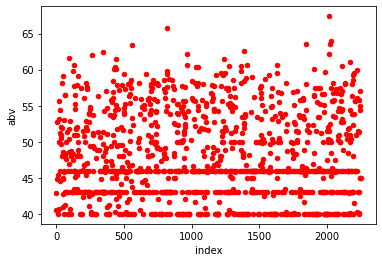

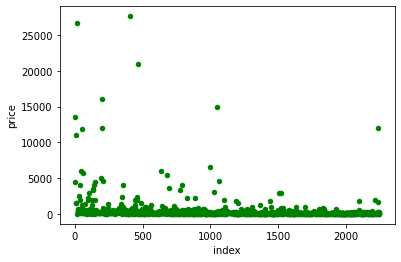

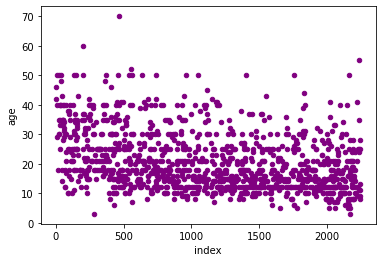

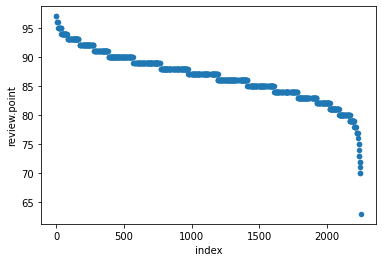

In [145]:
scotch_abv_test.reset_index().plot.scatter(x='index', y='abv', color='red')
scotch_abv_test.reset_index().plot.scatter(x='index', y='price', color='green')
scotch_abv_test.reset_index().plot.scatter(x='index', y='age', color='purple')
scotch_abv_test.reset_index().plot.scatter(x='index', y='review.point')

Usuwamy odstające dane

In [146]:
q1 = scotch_abv_test.quantile(0.25)
q3 = scotch_abv_test.quantile(0.75)
 
iqr = q3 - q1
iqr

review.point      6.0
price           150.0
age              13.0
abv               9.7
dtype: float64

In [147]:
outliers = (scotch_abv_test < (q1 - 3.0 * iqr)) | (scotch_abv_test > (q3 + 3.0 * iqr))
outliers.sum()

abv              0
age              1
category         0
name             0
price           97
review.point     1
dtype: int64

In [148]:
scotch_abv_test[outliers.any(1)]

,name,category,review.point,price,age,abv
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,42.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,46.0,42.9
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,40.0,44.8
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,50.0,52.8
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,96,1500.0,29.0,45.4
...,...,...,...,...,...,...
2094,"BenRiach 40 year old, 50%",Single Malt Scotch,80,1800.0,40.0,50.0
2218,"Auchentoshan 1962, 41 year old, 40.3%",Single Malt Scotch,77,2000.0,41.0,40.3
2236,"The Macallan Lalique Decanter, 55 year old, 40.1%",Single Malt Scotch,74,12000.0,55.0,40.1
2237,"Signatory (distilled at Kinclaith), Cask #3014...",Single Malt Scotch,73,1700.0,35.0,51.3


In [0]:
# scotch_abv_test.reset_index().plot.scatter(x='index', y='abv', c={"b": outliers.any(1), "r": ~outliers.any(1)})

In [150]:
no_outliers = ~(outliers).any(axis=1)

scotch_abv_test._update_inplace(scotch_abv_test[no_outliers])
scotch_abv_test.describe()

,review.point,price,age,abv
count,1095.000000,1095.000000,1095.000000,1095.000000
mean,86.378995,153.466667,19.180822,48.042091
std,3.995623,126.501456,8.359507,6.004217
min,70.000000,13.000000,3.000000,40.000000
25%,84.000000,70.000000,12.000000,43.000000
50%,87.000000,110.000000,18.000000,46.000000
75%,89.000000,180.000000,25.000000,52.850000
max,95.000000,665.000000,50.000000,67.400000


In [0]:
scotch_data = scotch_abv_test.copy()

## Rozkład wartości

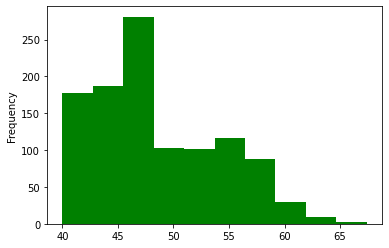

In [152]:
scotch_data['abv'].plot.hist(color='green')

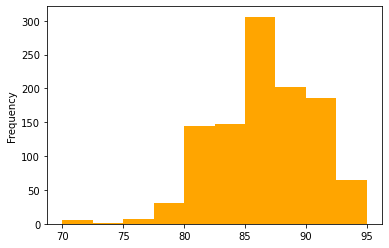

In [153]:
scotch_data['review.point'].plot.hist(color='orange')

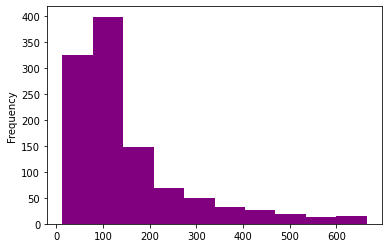

In [154]:
scotch_data['price'].plot.hist(color='purple')

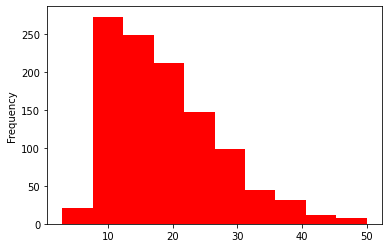

In [155]:
scotch_data['age'].plot.hist(color='red')

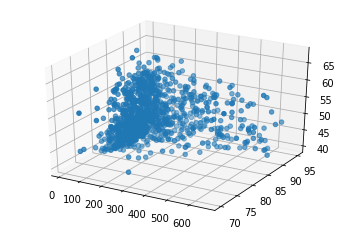

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['abv'])
plt.show()

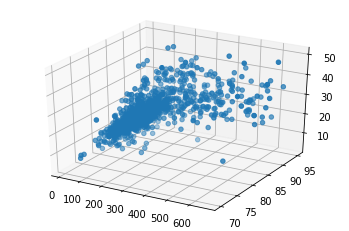

In [157]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'])
plt.show()

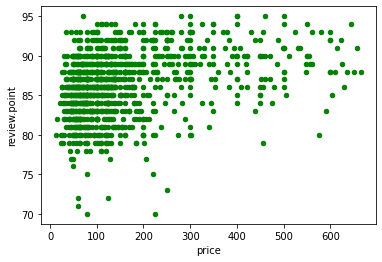

In [158]:
scotch_data.plot.scatter(x='price', y='review.point', color='green')

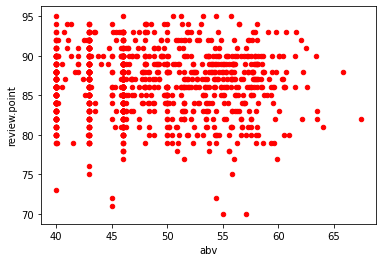

In [159]:
scotch_data.plot.scatter(x='abv', y='review.point', color='red')

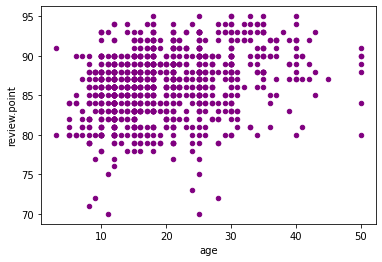

In [160]:
scotch_data.plot.scatter(x='age', y='review.point', color='purple')

Macierz korelacji

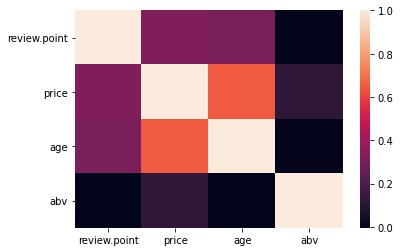

In [179]:
correlations = scotch_data.corr()

import seaborn as sns
sns.heatmap(correlations, 
        xticklabels=correlations.columns,
        yticklabels=correlations.columns)

In [0]:
# Czy to ma sens???
# from enum import Enum
# classes_numeric = Enum('WhiskyClass', list(scotch_data['category'].unique()), module=__name__)
# classes_numeric

In [0]:
# scotch_data['class_numeric_label'] = [classes_numeric[category].value for category in scotch_data['category']]
# scotch_data.corr()

## Klastrowanie

### K-Means

2 klastry

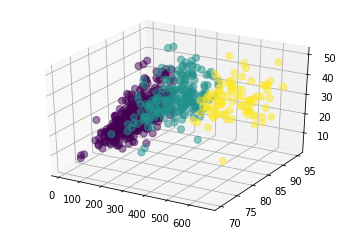

In [180]:
from sklearn.cluster import KMeans

clustering_data = scotch_data[['age', 'price', 'review.point']].copy()
kmeans = KMeans(n_clusters=2).fit(clustering_data)
# centroids = kmeans.cluster_centers_
# print(centroids)

threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()

3 klastry

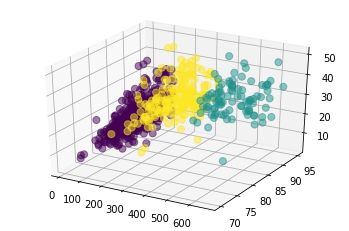

In [182]:
kmeans = KMeans(n_clusters=3).fit(clustering_data)
threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()

4 klastry

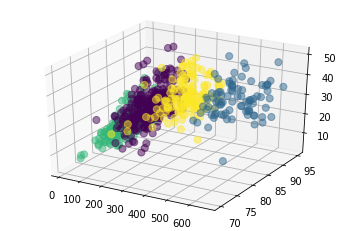

In [184]:
kmeans = KMeans(n_clusters=4).fit(clustering_data)
threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()

5 klastrów

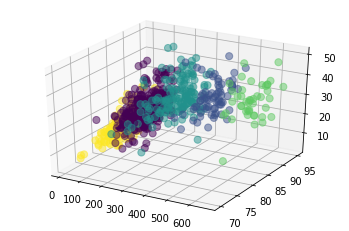

In [185]:
kmeans = KMeans(n_clusters=5).fit(clustering_data)
threedee = plt.figure().gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()